# TP - time series
## Julien GUEGAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy as scp
import math
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from statsmodels.tsa.ar_model import AR
import warnings
warnings.filterwarnings('ignore')

# 1)
Importez les données du fichier Openhealth_S-Grippal.csv. Consultez http://www.openhealth.fr/ias pour plus d’information sur les données. Affichez les 5 premières lignes du jeu de données.

In [2]:
df = pd.read_csv('Openhealth_S-Grippal.csv',sep=';',usecols=['PERIODE','IAS_brut'],na_values='0',decimal=",")
df = df.set_index('PERIODE')
df.head()

,IAS_brut
PERIODE,
2009-07-01,1.7
2009-07-02,3.4
2009-07-03,2.1
2009-07-04,1.3
2009-07-05,14.2


Pour cette variable, dans ce jeu de données, les cas de nullité correspondent à des données manquantes. 
Combien de données manquantes comporte-t-elle ?

In [3]:
df.isnull().sum()

IAS_brut    8
dtype: int64

Pour les traitements des questions suivantes, éliminez les données manquantes par imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non observées à partir des valeurs aux dates observées : par exemple par la moyenne de deux dates les plus proches.

In [4]:
df["IAS_brut"] = df["IAS_brut"].interpolate()
df.isnull().sum()

IAS_brut    0
dtype: int64

# 2)
Tracez la série temporelle considérée en fonction du temps. Commentez brièvement ce que vous
observez.

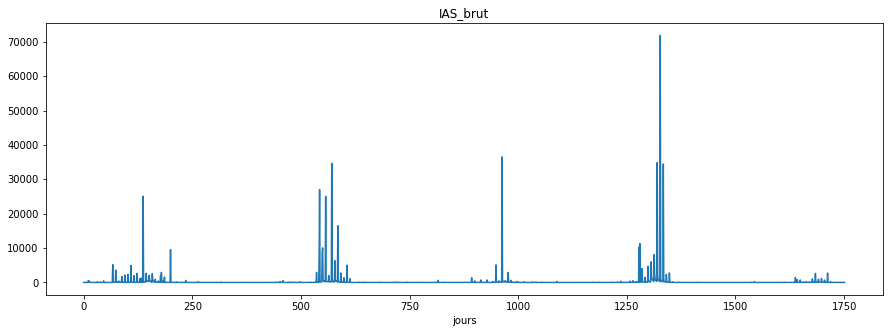

In [5]:
time_serie = df["IAS_brut"].values 

plt.figure(figsize=(15,5))
plt.plot(time_serie),plt.xlabel('jours'),plt.title('IAS_brut')
plt.show()

$\text{Il semble y avoir une périodicité annuel (365 jours).}$

# 3)
Tracez l’histogramme de la loi marginale. Quel impact la distribution observée par l’histogramme a sur la trajectoire représentée à la question précédente ?

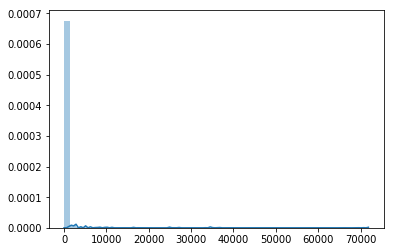

In [6]:
sns.distplot(time_serie)
plt.show()

$\text{On voit que beaucoup de nos données sont concentrées entre 0 et 1000 puis quelques unes s'étales jusqu'à 7000.}$

$\longrightarrow \text{Nos données ont une grande variance.}$

$\text{}$

# 4)
Reprenez les questions précédentes après tranformations des observations par le logarithme naturel. Commentez.

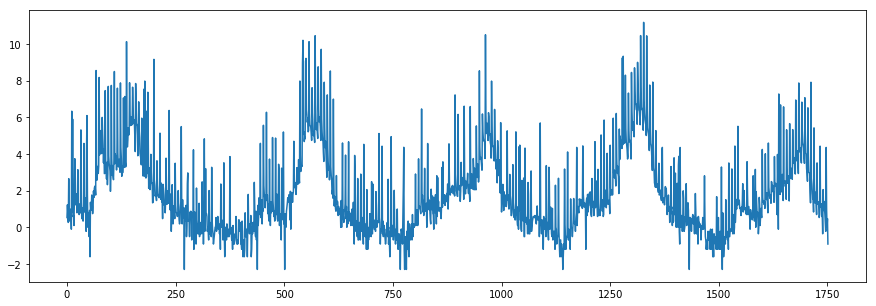

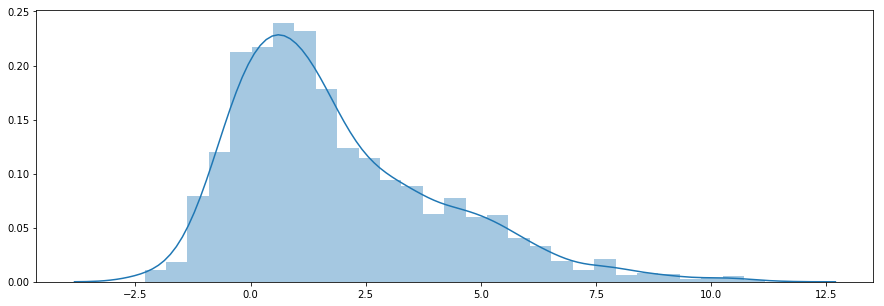

In [7]:
time_serie = np.log(time_serie)

plt.figure(figsize=(15,5))
plt.plot(time_serie)
plt.show()

plt.figure(figsize=(15,5))
sns.distplot(time_serie)
plt.show()

$\text{On a supprimé la variance élevée des données et on a gardé la période annuelle.}$

# 5)
En utilisant signal.periodogram() (du package signal importé depuis scipy), tracez le périodogramme
des données. Expliquez les pics les plus significatifs que vous observez. Attention au fait
que dans la communauté signal les spectres sont normalisées pour des fréquences absolues dans [1/2; 1/2] plutôt que [-pi;pi].

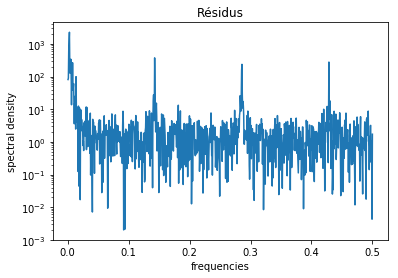

f = [0.00057078 0.00114155 0.00171233 0.00228311 0.00285388 0.00342466
 0.00399543 0.00456621 0.00513699]
Pxx_den = [  80.71434149   89.16412162  600.96157189 1250.73723266 2263.75298099
  232.99707446  126.21458221  167.16760569  338.53400131]


In [8]:
from scipy import signal

f, Pxx_den = signal.periodogram(time_serie)
plt.semilogy(f[1:],Pxx_den[1:])
plt.xlabel("frequencies"),plt.ylabel("spectral density"),plt.title('Résidus'),plt.show()
print("f =",f[1:10])
print("Pxx_den =",Pxx_den[1:10])

$T = 1/f$

$1/365 = 0.0027 \rightarrow \text{annuel}$

$1/30 = 0.03 \rightarrow \text{mensuel}$

$1/7 = 0.14 \rightarrow \text{hebdomadaire}$

$1/3.5 = 0.28  \rightarrow \text{bi-hebdomadaire}$

$1/2.3 = 0.43  \rightarrow \text{tous les 2.3 jours}$

# 6)
Pour supprimer une tendance périodique de période T dans un signal $(x_t)_{t\in Z}$ il suffit d’appliquer le filtre $\Delta T$ défini par
$[\Delta T x]_t = x_t - x_{t-T}$
Utilisez cette méthode pour supprimer la tendance périodique de période 1 an. Quel pic du périodogramme cette méthode a fait disparaître ?

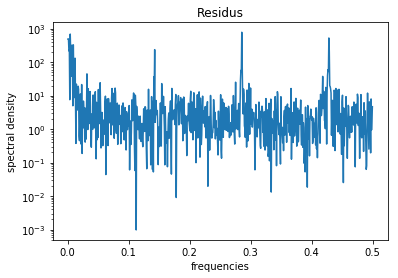

f = [0.00072098 0.00144196 0.00216294 0.00288392 0.0036049  0.00432588
 0.00504686 0.00576784 0.00648882]
Pxx_den = [491.58659522 493.81444691 216.71596086 234.06320019   7.54447973
 687.79507523 206.67745437  37.51655178 166.96696858]


In [9]:
T = 365
accroissement = []
for i in range(T,len(time_serie)):
    accroissement.append(time_serie[i] - time_serie[i-T])

f, Pxx_den = signal.periodogram(accroissement)
plt.semilogy(f[1:],Pxx_den[1:])
plt.xlabel("frequencies"),plt.ylabel("spectral density"),plt.title('Residus'),plt.show()
print("f =",f[1:10])
print("Pxx_den =",Pxx_den[1:10])

$\text{Le pic à ~0.0028 a disparu, c'est celui qui correspond à la periode annuelle}$

# 7)
Tracez les valeur de la série temporelle et votre prédiction pour l’ensemble de données (vous pouvez utilisez les couleurs différentes pour pour les partie apprentissage et prédiction). Puis, donnez le risque quadratique de la prédiction et tracez les résidus pour la période prédite.

In [10]:
import sklearn.linear_model as linear_model

ti = np.arange(1,1369)
n_harm = 12
x_train = np.zeros((len(ti),2*n_harm))
for k in range(0,n_harm):
    x_train[:,2*k]   = np.cos( ti * (k+1) * 2*math.pi/T)
    x_train[:,2*k+1] = np.sin( ti * (k+1) * 2*math.pi/T)
    
y_train = time_serie[0:1368]

regr = linear_model.LinearRegression()
regr.fit(x_train,y_train)
regr_score = regr.score(x_train,y_train)
print('score:', regr_score)

score: 0.44119388853345554


In [11]:
# prediction
t_pred = np.arange(1,1753)
x_pred = np.zeros((len(t_pred),2*n_harm))
for k in range(0,n_harm):
    x_pred[:,2*k]   = np.cos( t_pred * (k+1) * 2*math.pi/T)
    x_pred[:,2*k+1] = np.sin( t_pred * (k+1) * 2*math.pi/T)

regr_predict = regr.predict(x_pred)

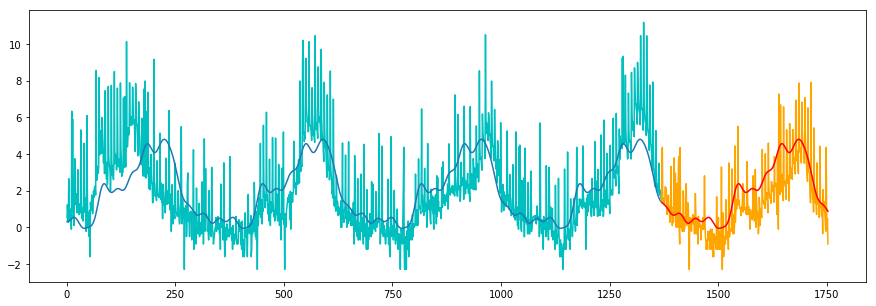

In [12]:
plt.figure(figsize=(15,5))
plt.plot(ti,y_train,'c-')
plt.plot(t_pred[0:1368],regr_predict[0:1368],'-')
plt.plot(np.arange(1369,1753),time_serie[1368:1753],'-',color='orange')
plt.plot(t_pred[1369:1753],regr_predict[1369:1753],'r-')
plt.show()

$\text{L'erreur quadratique est plus faible avec n_harm = 12 qu'avec n_harm = 5}$

MSE_total = 2.8204855920906398
MSE = 1.8826896797318635


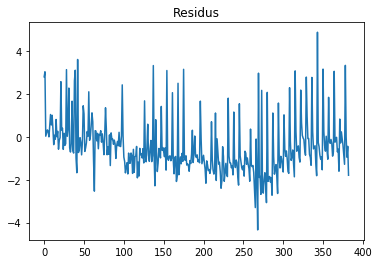

In [13]:
residus = time_serie - regr_predict
plt.plot(residus[1369:1753]),plt.title('Residus')
print("MSE_total =",np.mean(residus ** 2))
print("MSE =",np.mean((time_serie[1369:1753] - regr_predict[1369:1753])**2))

# 8)
Créez la série temporelle, où chaque observation correspond au nombre de paquets transmis dans un intervalle de 10 secondes. Il y a 720 intervalles, donc vous devez obtenir 720 observations. Tracez la série temporelle obtenue.

In [14]:
df2 = pd.read_csv('lbl-tcp-3.tcp.txt',header=None,sep=' ',names=['timestamp','source host','destination host','source TCP port','destination TCP port','number of data bytes'])
df2.head()

,timestamp,source host,destination host,source TCP port,destination TCP port,number of data bytes
0,0.008185,1,2,23,2436,1
1,0.010445,2,1,2436,23,2
2,0.023775,1,2,23,2436,2
3,0.026558,2,1,2436,23,1
4,0.029002,3,4,3930,119,42


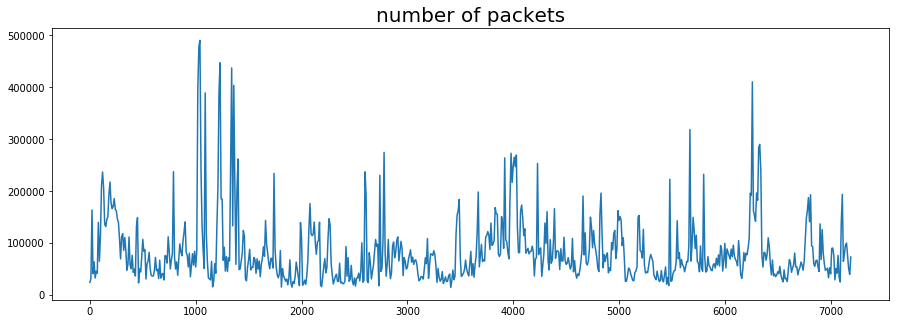

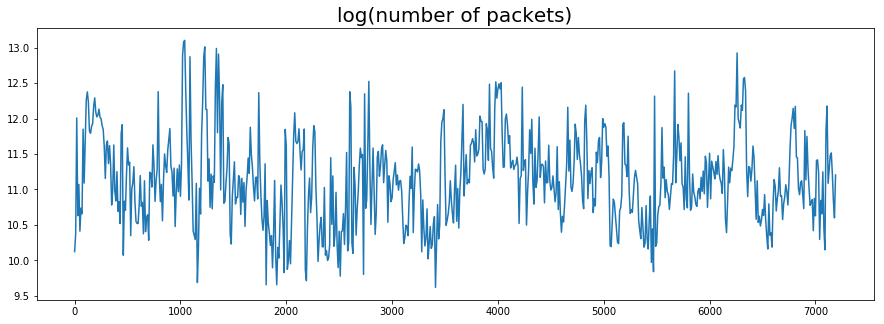

In [15]:
times = np.arange(0,7201,10)
time_serie = np.zeros((len(times)-1))
for i,time in enumerate(times[:len(times)-1]):
    interval = (times[i] < df2["timestamp"]) & (df2["timestamp"] < times[i+1])
    time_serie[i] = sum(df2["number of data bytes"].iloc[np.where(interval)])
times = times[:len(times)-1]
time_serie = time_serie/4 # 1 packets = 4 bytes

plt.figure(figsize=(15,5))
plt.plot(times,time_serie),plt.title("number of packets",fontsize=20)
plt.show()

time_serie = np.log(time_serie)
plt.figure(figsize=(15,5))    
plt.plot(times,time_serie), plt.title("log(number of packets)",fontsize=20)
plt.show()

# 9)
Construire un modèle auto-régressif AR(p). Pour une gamme de valeur choisie, effectuer les trois méthodes de la sélection du modèle : critère d’information d’Akaike (AIC), critère d’information bayésien (BIC) et validation croisée/backtesting.

In [16]:
p_values = np.arange(0,10)
AIC = []
BIC = []
MSE_mean = []
for p in p_values:
    try:
        model_fit = ARIMA(time_serie,order=(p,0,0)).fit()
    except:
        continue
    AIC.append(model_fit.aic)
    BIC.append(model_fit.bic)

    # cross-validation
    MSE = []
    n_splits=5
    tscv = TimeSeriesSplit(n_splits)
    for train_index, test_index in tscv.split(time_serie):
        try:
            model_fit = ARIMA(time_serie[train_index],order=(p,0,0)).fit()
        except:
            continue
        y_pred = model_fit.predict(start=test_index[0], end=test_index[-1])    
        MSE.append((y_pred - time_serie[test_index]) ** 2)
    MSE_mean.append(np.mean(MSE))

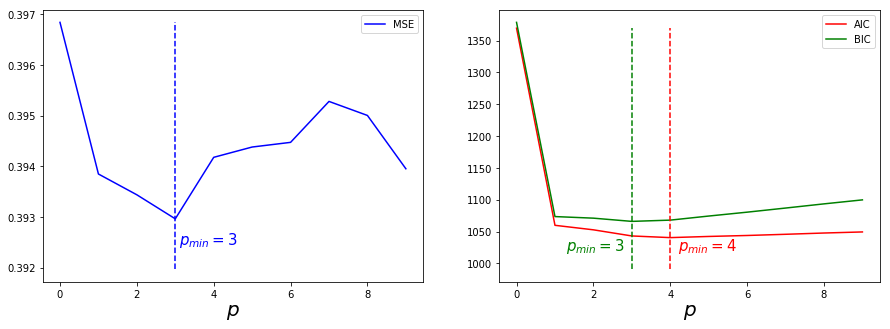

In [17]:
AIC_min = p_values[np.argmin(AIC)]
BIC_min = p_values[np.argmin(BIC)]
MSE_min = p_values[np.argmin(MSE_mean)]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(p_values,MSE_mean,'b-',label='MSE')
plt.plot([MSE_min,MSE_min],[np.min(MSE_mean)-0.001,np.max(MSE_mean)],'b--')
plt.text(MSE_min+0.1,np.min(MSE_mean)-0.0005,'$p_{min}='+str(MSE_min)+'$',color='b',size=15)
plt.xlabel('$p$',fontsize=20)
plt.legend()

plt.subplot(122)
plt.plot(p_values,AIC,'r',label='AIC')
plt.plot(p_values,BIC,'g',label='BIC')
plt.plot([BIC_min,BIC_min],[np.min(AIC)-50,np.max(AIC)],'g--')
plt.plot([AIC_min,AIC_min],[np.min(AIC)-50,np.max(AIC)],'r--')
plt.text(BIC_min-1.7,np.min(AIC)-20,'$p_{min}='+str(BIC_min)+'$',color='g',size=15)
plt.text(AIC_min+0.2,np.min(AIC)-20,'$p_{min}='+str(AIC_min)+'$',color='r',size=15)
plt.xlabel('$p$',fontsize=20)
plt.legend()
plt.show()

# 10)
En ce basant sur les résultats de la question précédente, sélectionnez l’ordre p du modèle AR à estimer et affichez les paramètres correspondants. Tracez les résidus. Tracez l’estimation de la densité de résidus et la densité de la distribution
normale (avec moyenne et écart-type estimés) sur le même graphique et comparez les visuellement. Commentez.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  720
Model:                     ARMA(3, 0)   Log Likelihood                -516.527
Method:                       css-mle   S.D. of innovations              0.496
Date:                Wed, 30 Oct 2019   AIC                           1043.054
Time:                        22:27:29   BIC                           1065.950
Sample:                             0   HQIC                          1051.893
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1357      0.058    191.021      0.000      11.021      11.250
ar.L1.y        0.5121      0.037     13.842      0.000       0.440       0.585
ar.L2.y        0.0450      0.042      1.079      0.2

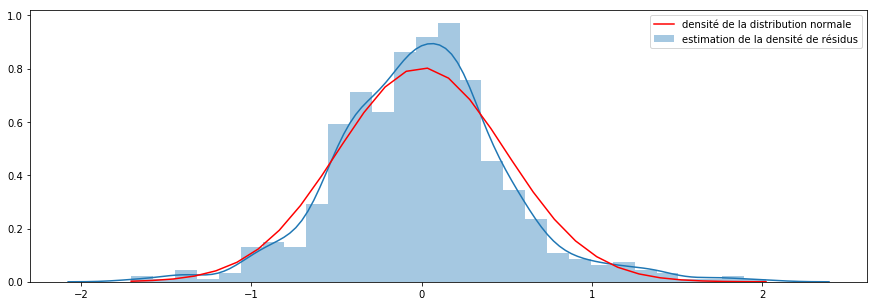

In [18]:
model = ARIMA(time_serie,order=(MSE_min,0,0))
model_fit = model.fit()
y_pred = model_fit.predict(start=0, end=len(time_serie)-1)    
print(model_fit.summary())

residus = time_serie - y_pred
mu = np.mean(residus)
sigma = np.sqrt(np.var(residus))
print("mean = "+str(mu),"; std ="+str(sigma) )


plt.figure(figsize=(15,5))
sns.distplot(residus,label='estimation de la densité de résidus')
hist, bin_edges = np.histogram(residus, bins=30, density=True)
plt.plot(bin_edges,norm.pdf(bin_edges,mu,sigma),'r',label='densité de la distribution normale')
plt.legend()
plt.show()

$\text{On remarque que les résidus ne suivent pas tout à fait une loi normale, donc le modèle de prédiction pourrait sûrement être meilleur.}$

# 11)
Importez les données du fichier soi.tsv. Consultez http://www.bom.gov.au/climate/glossary/soi.shtml pour plus d’information sur les données. Supprimez les données manquantes.

In [19]:
df3 = pd.read_csv('soi.tsv',header=None,sep='\t',na_values='nan').transpose()
df3 = df3.dropna()
time_serie = df3.values

# 12)
A l’aide des fonctions plot_acf() et plot_pacf() importées de statsmodels.graphics.tsaplots,
tracez la fonction d’autocorrélation et la fonction d’autocorrélation partielle.

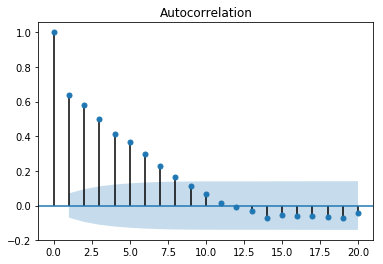

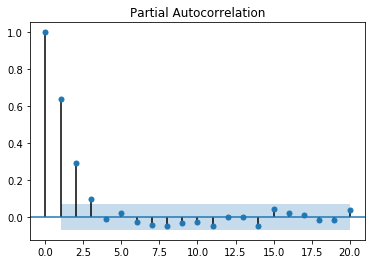

In [20]:
plot_acf(time_serie,lags=20);
plot_pacf(time_serie,lags=20);

# 13)
En ce basant sur la question précédente, choisissez l’ordre du processus auto-régressive AR(p).
Entrainer le modèle AR choisi. Tracez les résidus. Tracez l’estimation de la densité de résidus et la
densité de la distribution normale (avec moyenne et écart-type estimés) sur le même graphique et
comparez les visuellement. Commentez.

$\text{On choisit } p \text{ comme étant la valeur où le PACF traverse la zone de confiance pour la première fois. }$

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  780
Model:                     ARMA(4, 0)   Log Likelihood                -821.290
Method:                       css-mle   S.D. of innovations              0.693
Date:                Wed, 30 Oct 2019   AIC                           1654.579
Time:                        22:27:30   BIC                           1682.535
Sample:                             0   HQIC                          1665.331
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1288      0.106      1.214      0.225      -0.079       0.337
ar.L1.y        0.4226      0.036     11.793      0.000       0.352       0.493
ar.L2.y        0.2530      0.039      6.531      0.0

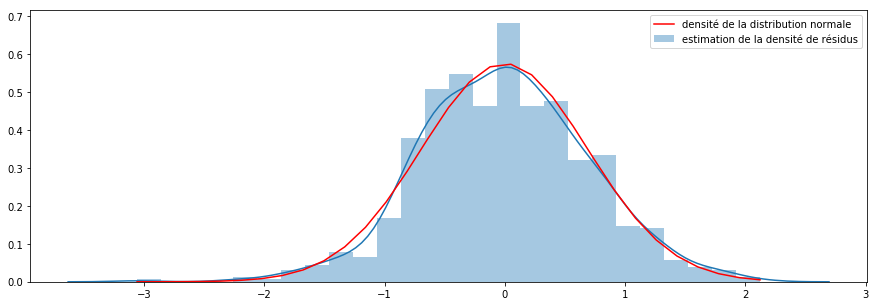

In [21]:
model = ARIMA(time_serie,order=(4,0,0))
model_fit = model.fit()
y_pred = model_fit.predict(start=0, end=len(time_serie)-1).reshape(-1,1) 
print(model_fit.summary())

residus = time_serie - y_pred
mu = np.mean(residus)
sigma = np.sqrt(np.var(residus))
print("mean = "+str(mu),"; std ="+str(sigma) )


plt.figure(figsize=(15,5))
sns.distplot(residus,label='estimation de la densité de résidus')
hist, bin_edges = np.histogram(residus, bins=30, density=True)
plt.plot(bin_edges,norm.pdf(bin_edges,mu,sigma),'r',label='densité de la distribution normale')
plt.legend()
plt.show()

$\text{On remarque que les résidus suivent plutôt bien une loi normale, ils correspondent bien au bruit du modèle.}$

$\text{On peut donc dire que notre modèle modélise bien le phénomène.}$

# 14)
Tracez le périodogramme ; superposez le à la densité spectrale du modèle estimé à la question précédente.
$$ f(\omega) = \sigma^2 \left| 1 - \sum_{k=1}^p \phi_k e^{-2i\pi k\omega} \right|^{-2} $$

In [22]:
f, Pxx_den = signal.periodogram(time_serie,axis=0)

In [23]:
def spectral_density(w,p,phi,sigma):
    s = 0
    for k in np.arange(1,p+1):
        s += phi[k-1]*np.exp(-2j*np.pi*k*w)
    return sigma**2 * np.abs(1 - s) ** (-2)

In [24]:
phi = model_fit.params[1:]
spectral_densities = []
for f_i in np.arange(0,0.5,0.001):
    w = 2*np.pi*f_i
    spectral_densities.append(spectral_density(w,4,phi,sigma))

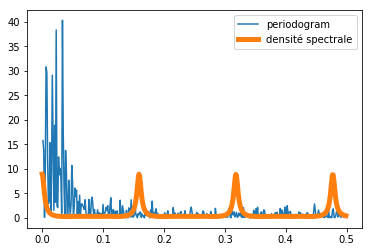

In [25]:
plt.plot(f[1:],Pxx_den[1:],label='periodogram')
plt.plot(np.arange(0,0.5,0.001),spectral_densities,linewidth=5,label='densité spectrale')
plt.legend()
plt.show()